In [2]:
import os
print(os.getcwd())

C:\Users\Administrator


In [3]:
os.chdir('D:/handwritten')
print(os.getcwd())

D:\handwritten


In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


# 1. Dataset preparation

In [8]:
#Dataset preparation
import os
import xml.etree.ElementTree as ET

# Define the directory containing XML files
directory = "D:/handwritten/xml/"

# Initialize a list to hold all words from all files
all_words = []

# Loop through each XML file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".xml"):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get the handwritten part's text content and word tags
        for word in root.findall(".//handwritten-part/line/word"):
            word_text = word.attrib['text']
            #word_id = word.attrib['id']
            word_id = word.attrib['id']
            u3_path = word_id+'.png'
            if(word_id[8]=="-"):
                u2_path = word_id[:8]+'/'
            else:
                u2_path = word_id[:7]+'/'
            u1_path = word_id[:3]+'/'
            word_path = u1_path+u2_path+u3_path
            all_words.append((word_path, word_text))

# Now 'all_words' contains words from all XML files in the directory


In [9]:
len(all_words)
# print(all_words[:100])

115320

## 1.1 Get the top 100 elements with the most occurrences and their times

In [10]:
# Count word frequency

from collections import Counter

labels = [label for _, label in all_words]

# Count the number of occurrences of each element
label_counts = Counter(labels)

# Get the top 100 elements with the most occurrences and their times
top_100_labels_counts = label_counts.most_common(100)

# Print results
for label, count in top_100_labels_counts:
    print(f"Label {label} appears {count} times")

Label the appears 5826 times
Label , appears 5570 times
Label . appears 4984 times
Label of appears 3192 times
Label to appears 2651 times
Label and appears 2475 times
Label a appears 2264 times
Label in appears 1802 times
Label " appears 1599 times
Label was appears 1135 times
Label that appears 1127 times
Label is appears 982 times
Label he appears 885 times
Label for appears 840 times
Label ' appears 837 times
Label with appears 743 times
Label I appears 743 times
Label had appears 733 times
Label be appears 723 times
Label his appears 709 times
Label it appears 703 times
Label as appears 702 times
Label on appears 697 times
Label The appears 626 times
Label at appears 563 times
Label by appears 490 times
Label not appears 479 times
Label which appears 425 times
Label have appears 422 times
Label but appears 419 times
Label her appears 410 times
Label an appears 401 times
Label from appears 384 times
Label are appears 383 times
Label been appears 373 times
Label you appears 367 time

In [11]:
from collections import Counter
# Extract tags and count occurrences
labels = [label for _, label in all_words]
label_counts = Counter(labels)

# Sort and find the tags with the top 100 occurrences
top_100_labels = [label for label, count in label_counts.most_common(100)]

# Filter the data and only retain elements with the top 100 tags
filtered_words = [item for item in all_words if item[1] in top_100_labels]

len(filtered_words)

60262

## 1.2 Convert to grayscale image, Proportionally resize, Convert image to 1D array

In [12]:
# Proportional scaling resize
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image, ImageOps

data = filtered_words  

# prepare features and labels
features = []
labels = []

def resize_and_pad(img, desired_size=64):
    # Calculate proportional scaling ratio
    ratio = desired_size / max(img.size)
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    # Create a new background canvas
    new_img = Image.new("L", (desired_size, desired_size), "black")
    # Paste the image in the center
    new_img.paste(img, ((desired_size - new_size[0]) // 2, (desired_size - new_size[1]) // 2))
    
    return new_img

for image_path, label in data:
    try:
        # Convert to grayscale image
        img = Image.open('words/' + image_path).convert('L')
        
        # Scale proportionally and fill to specified size
        img = resize_and_pad(img, 64)
        
        # Convert image to 1D array
        feature = np.array(img).flatten()
        
        # If the image is loaded successfully, add features and labels to the list
        features.append(feature)
        labels.append(label)
    except IOError:
        # If the image fails to load (e.g. the file does not exist), this sample is skipped
        print(f"Warning: Could not load image {image_path}. It will be skipped.")

# Convert to numpy array
features = np.array(features)
labels = np.array(labels)

In [16]:
np.save('top100_features_Proportional.npy', features)

In [14]:
np.save('top100_Labels_Proportional.npy', labels)

## 1.3 PCA, Correlation matrix analysis

In [10]:
import numpy as np
features = np.load('top100_features_Proportional.npy')

In [12]:
#PCA, try different percentage of the variance here 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Step 1: standardized features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2:  PCA
# Choose to retain 90% of the variance to determine the number of principal components
pca = PCA(n_components=0.90)
features_pca = pca.fit_transform(features_scaled)

# Check the dimensions of the new feature space
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_pca.shape[1])


Original number of features: 4096
Reduced number of features: 92


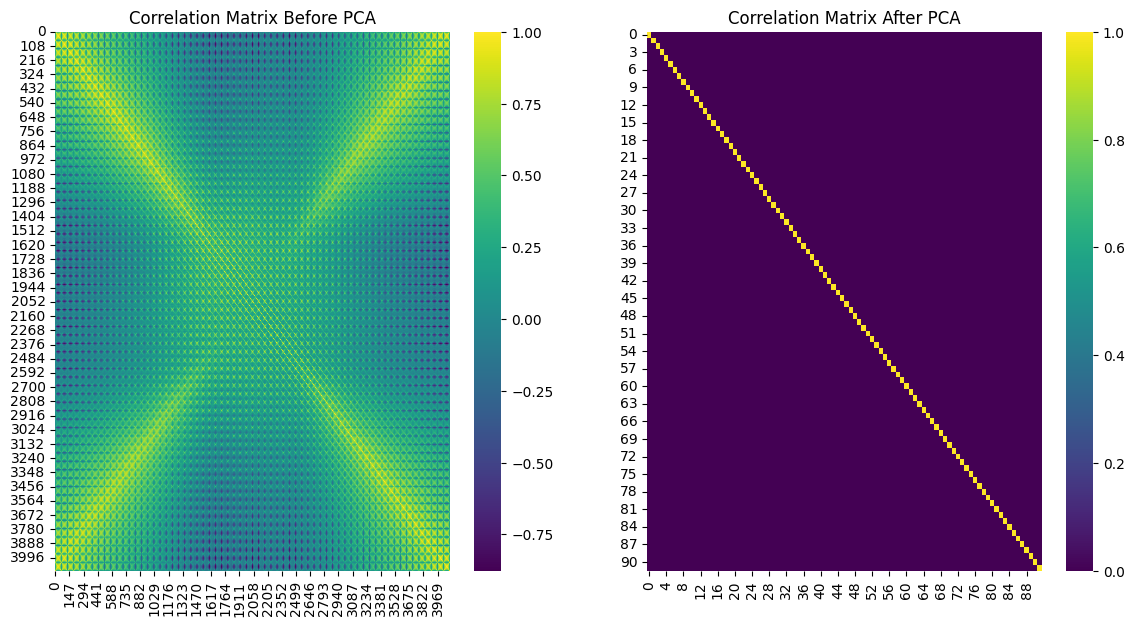

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix before PCA
corr_matrix_before = np.corrcoef(features_scaled.T)

# Calculate the correlation matrix after PCA
corr_matrix_after = np.corrcoef(features_pca.T)

# Set up canvas
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot heatmap of correlation matrix before and after PCA
sns.heatmap(corr_matrix_before, ax=ax[0], cmap='viridis')
ax[0].set_title('Correlation Matrix Before PCA')

sns.heatmap(corr_matrix_after, ax=ax[1], cmap='viridis')
ax[1].set_title('Correlation Matrix After PCA')

plt.show()

In [9]:
np.save('top100_features_Proportional_85_pca.npy', features_pca)

In [10]:
np.save('top100_features_Proportional_90_pca.npy', features_pca)

## KNN training and Evaluation 

In [25]:
import numpy as np
features_pca = np.load('top100_features_Proportional_90_pca.npy')

In [18]:
labels = np.load('top100_Labels_Proportional.npy')

In [26]:
features_pca.shape

(60261, 92)

## Simple KNN, only neighbors considered 

In [27]:
#Simple KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


X = features_pca
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))

KNN Classification Report:
              precision    recall  f1-score   support

           !       0.53      0.36      0.43        45
           "       0.70      0.38      0.49       312
           '       0.29      0.05      0.08       165
          's       0.31      0.14      0.19        29
           (       0.46      0.49      0.47        35
           )       0.30      0.26      0.28        42
           ,       0.66      0.89      0.76      1113
           -       0.55      0.89      0.68        65
           .       0.67      0.90      0.77       964
         ...       0.73      0.54      0.62        35
           :       0.86      0.60      0.71        40
           ;       0.88      0.13      0.22        55
           ?       0.68      0.27      0.38        56
           A       0.50      0.03      0.05        38
         And       0.09      0.04      0.05        26
         But       0.06      0.02      0.03        45
          He       0.22      0.06      0.09        71


C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

## KNN grid search for best hyperparameter

In [30]:
#KNN grid search for best hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = features_pca
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 30, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan'],
}

#Initialize grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the model with the best parameters for prediction
best_knn = grid_search.best_estimator_
knn_predictions = best_knn.predict(X_test)

# Output classification report and accuracy
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))


Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.50039412 0.5373797  0.50039412 0.5373797  0.51647031 0.54273151
 0.51647031 0.54273151 0.51516336 0.53383251 0.51516336 0.53383251
 0.50555909 0.52115823 0.50555909 0.52115823 0.49643201 0.50977005
 0.49643201 0.50977005        nan 0.52136568        nan 0.52136568
        nan 0.52640638        nan 0.52640638        nan 0.5184409
        nan 0.5184409         nan 0.50721859        nan 0.50721859
        nan 0.49518737        nan 0.49518737 0.50039412 0.5373797
 0.50039412 0.5373797  0.51647031 0.54273151 0.51647031 0.54273151
 0.51516336 0.53383251 0.51516336 0.53383251 0.50555909 0.52115823
 0.50555909 0.52115823 0.49643201 0.50977005 0.49643201 0.50977005
        nan 0.52136568        nan 0.52136568        nan 0.52640638
        nan 0.52640638        nan 0.5184409         nan 0.5184409
        nan 0.50721859        nan 0.507

Best parameters found:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNN Classification Report:
              precision    recall  f1-score   support

           !       0.62      0.33      0.43        45
           "       0.70      0.45      0.55       312
           '       0.27      0.07      0.11       165
          's       0.42      0.17      0.24        29
           (       0.53      0.57      0.55        35
           )       0.30      0.24      0.27        42
           ,       0.71      0.87      0.78      1113
           -       0.60      0.86      0.70        65
           .       0.72      0.90      0.80       964
         ...       0.95      0.57      0.71        35
           :       0.80      0.70      0.75        40
           ;       0.60      0.22      0.32        55
           ?       0.77      0.41      0.53        56
           A       0.21      0.08      0.12        38
         And       0.00      0.00      0.00     

##  KNN For tuning hyperparameter manually

In [28]:
#KNN For tuning hyperparameter manually
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = features_pca
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier(
    n_neighbors=10,  # number of neighbors
    weights='distance',  # Set the weight to the reciprocal of the distance
    algorithm='auto',  # Algorithm selection, here let the model automatically select the most appropriate algorithm
    leaf_size=30,  # leaf size
    p=2,  # The power parameter of Minkowski distance, p=2 represents Euclidean distance
    metric='minkowski',  # distance metric
    n_jobs=-1  # Use all CPU cores for calculations
)

# Training model
knn.fit(X_train, y_train)

# make predictions
knn_predictions = knn.predict(X_test)

# Output classification report and accuracy
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))


KNN Classification Report:
              precision    recall  f1-score   support

           !       0.64      0.36      0.46        45
           "       0.75      0.38      0.50       312
           '       0.42      0.05      0.09       165
          's       0.50      0.14      0.22        29
           (       0.48      0.46      0.47        35
           )       0.36      0.24      0.29        42
           ,       0.69      0.89      0.78      1113
           -       0.57      0.85      0.68        65
           .       0.69      0.90      0.78       964
         ...       0.90      0.54      0.68        35
           :       0.88      0.70      0.78        40
           ;       0.62      0.15      0.24        55
           ?       0.72      0.32      0.44        56
           A       0.43      0.08      0.13        38
         And       0.20      0.04      0.06        26
         But       0.00      0.00      0.00        45
          He       0.10      0.01      0.02        71


## Evaluation cell 

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report

# Calculate evaluation indicators
accuracy = accuracy_score(y_test, knn_predictions)
precision = precision_score(y_test, knn_predictions, average='macro')  # 'macro' 未加权平均，'weighted' 为加权平均
recall = recall_score(y_test, knn_predictions, average='macro')
f1 = f1_score(y_test, knn_predictions, average='macro')
mcc = matthews_corrcoef(y_test, knn_predictions)
conf_matrix = confusion_matrix(y_test, knn_predictions)
class_report = classification_report(y_test, knn_predictions)

#Print evaluation indicators
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.5625985231892475
Precision: 0.3833097932139076
Recall: 0.3070987623011829
F1 Score: 0.32341530212169417
Matthews Correlation Coefficient: 0.5423980228877368

Confusion Matrix:
 [[ 15   0   0 ...   0   0   0]
 [  1 141   4 ...   0   0   1]
 [  0   6  12 ...   0   0   0]
 ...
 [  0   0   0 ...  81   5   0]
 [  0   0   0 ...   1  25   0]
 [  0   0   0 ...   1   0  48]]

Classification Report:
               precision    recall  f1-score   support

           !       0.62      0.33      0.43        45
           "       0.70      0.45      0.55       312
           '       0.27      0.07      0.11       165
          's       0.42      0.17      0.24        29
           (       0.53      0.57      0.55        35
           )       0.30      0.24      0.27        42
           ,       0.71      0.87      0.78      1113
           -       0.60      0.86      0.70        65
           .       0.72      0.90      0.80       964
         ...       0.95      0.57      0.71        35

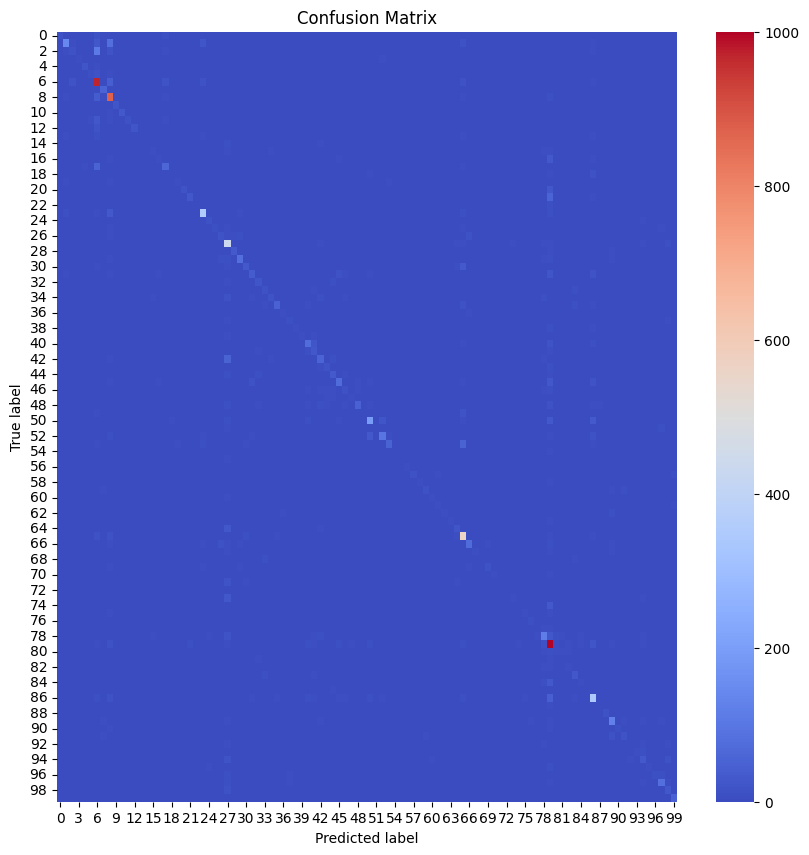

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))  
sns.heatmap(conf_matrix, annot=False, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Random input test here 

In [19]:
# Prediction
# Input an image
new_image_path = '"D:\handwritten\r06-018-00-02.png"'
new_img = Image.open(new_image_path).convert('L')  # Convert to grayscale image
new_img = new_img.resize((64, 64), Image.Resampling.LANCZOS)  # Resize
new_feature = np.array(new_img).flatten().reshape(1, -1)  # Convert image to 1D array

predicted_label = knn.predict(new_feature)
print(predicted_label)

['.']
